<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Weekly_Series_Momentum_Signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

In [48]:
from datetime import datetime
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
ls_key = 'Adj Close'
start = datetime(2018,1,1)
 
df = yf.download(tickers,start, freq='w')
prices = df[[("Adj Close", s) for s in tickers]]
prices.columns = prices.columns.droplevel(level=0)
prices

[*********************100%***********************]  8 of 8 completed


,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,13.350000,9.470000,42.480000,6.300000,108.726067,38.072212,80.010002,61.160000
2018-01-03,12.900000,9.510000,42.970001,6.500000,109.192856,39.001244,84.010002,61.939999
2018-01-04,12.900000,9.720000,42.130001,6.990000,109.144241,40.203526,78.550003,63.000000
2018-01-05,12.650000,9.900000,42.610001,6.820000,108.551003,40.085114,77.739998,63.650002
2018-01-08,13.150000,9.790000,42.759998,6.590000,106.994995,40.276390,74.639999,64.400002
...,...,...,...,...,...,...,...,...
2021-07-30,54.560001,114.519997,106.260002,82.800003,176.020004,56.840000,87.870003,135.449997
2021-08-02,54.540001,112.330002,107.519997,85.080002,175.550003,57.029999,86.980003,131.070007
2021-08-03,56.419998,110.839996,104.589996,83.250000,172.990005,57.880001,85.989998,132.410004


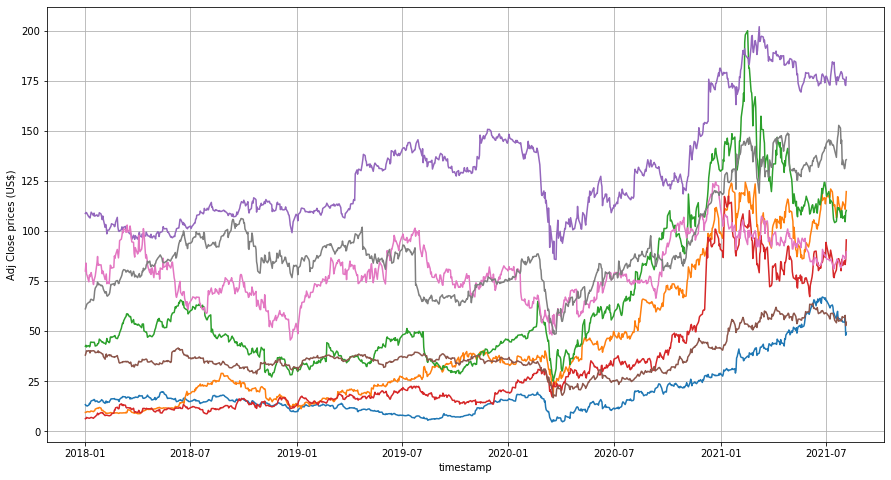

In [3]:
plt.figure(figsize= (15,8))
plt.plot(prices, label = 'Daily Closing price' )
# plt.xticks([])
plt.ylabel('Adj Close prices (US$)'); plt.xlabel('timestamp')
plt.grid(True); plt.show()

In [4]:
import numpy as np


In [51]:
import matplotlib.dates as mpl_dates
df = prices.copy()
df.reset_index(inplace=True)
df['Date']=df['Date'].apply(mpl_dates.date2num)
df = df.astype(float)

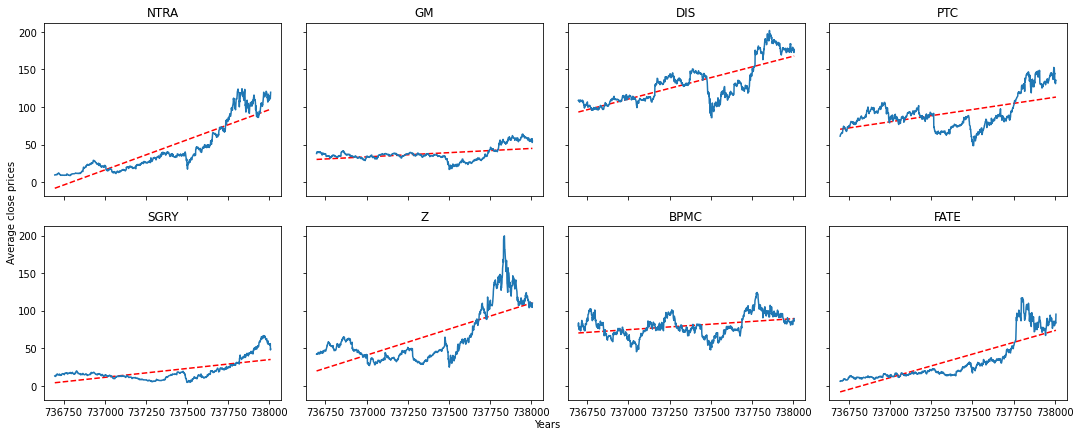

In [56]:
# y = prices['value'].tolist()
# X = dates.date2num(list(pd.to_datetime(x)))
X = df.Date.values
fig, ax = plt.subplots(2, 4, figsize=(15,6), sharex=True, sharey=True)

# SGRY
z = np.polyfit(X, df['SGRY'].values, 1)
p = np.poly1d(z)
ax[1, 0].plot(X,p(X),"r--")
ax[1, 0].plot(X, df['SGRY'])
ax[1, 0].set_title('SGRY', fontsize=12)

# NTRA
z = np.polyfit(X, df['NTRA'].values, 1)
p = np.poly1d(z)
ax[0, 0].plot(X,p(X),"r--")
ax[0, 0].plot(X, df['NTRA'] )
ax[0, 0].set_title('NTRA', fontsize=12)

# Z
z = np.polyfit(X, df['Z'], 1)
p = np.poly1d(z)
ax[1, 1].plot(X,p(X),"r--")
ax[1, 1].plot(X, df['Z'])
ax[1, 1].set_title('Z', fontsize=12)

# BPMC
z = np.polyfit(X, df['BPMC'], 1)
p = np.poly1d(z)
ax[1, 2].plot(X,p(X),"r--")
ax[1, 2].plot(X,  df['BPMC'])
ax[1, 2].set_title('BPMC', fontsize=12)

# FATE
z = np.polyfit(X, df['FATE'], 1)
p = np.poly1d(z)
ax[1, 3].plot(X,p(X),"r--")
ax[1, 3].plot(X,  df['FATE'])
ax[1, 3].set_title('FATE', fontsize=12)

# GM
z = np.polyfit(X, df['GM'], 1)
p = np.poly1d(z)
ax[0, 1].plot(X,p(X),"r--")
ax[0, 1].plot(X,  df['GM'])
ax[0, 1].set_title('GM', fontsize=12)

# GM
z = np.polyfit(X, df['DIS'], 1)
p = np.poly1d(z)
ax[0, 2].plot(X,p(X),"r--")
ax[0, 2].plot(X,  df['DIS'])
ax[0, 2].set_title('DIS', fontsize=12)

# PTC
z = np.polyfit(X, df['PTC'], 1)
p = np.poly1d(z)
ax[0, 3].plot(X,p(X),"r--", label = 'Trend line')
ax[0, 3].plot(X,  df['PTC'])
ax[0, 3].set_title('PTC', fontsize=12)

# Draw the plot
fig.text(0.5, 0.00, 'Years', ha='center')
fig.text(0.00, 0.5, 'Average close prices', va='center', rotation='vertical')
plt.tight_layout()

In [4]:
# monthly_ret = prices.pct_change().resample('m').agg(lambda x: (x+1).prod() - 1)
# monthly_ret

In [18]:
# returns = prices.copy()
weekly_returns = prices.resample('w').mean().pct_change()
# prices.pct_change().resample('w').agg(lambda x: (x+1).prod() - 1)


# returns.apply(lambda x: x.shift(-1)/x - 1, axis = 0)
weekly_returns # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,0.093436,0.026943,0.017639,0.011950,-0.012542,0.016519,-0.032188,0.041746
2018-01-21,0.098164,0.046670,0.013269,0.042038,0.003070,-0.002243,-0.023806,0.050827
2018-01-28,-0.049518,0.123548,0.005687,0.231646,0.000293,-0.007111,0.111969,0.075143
2018-02-04,0.038566,-0.085979,0.012103,0.064120,-0.009446,-0.027221,-0.044719,-0.016439
...,...,...,...,...,...,...,...,...
2021-07-11,-0.053626,0.019570,-0.042257,-0.028662,-0.011585,-0.029258,-0.022242,0.016977
2021-07-18,-0.034351,-0.026625,-0.074559,-0.089868,0.051092,0.007070,-0.038163,-0.016805
2021-07-25,-0.047342,-0.023180,0.013571,0.057189,-0.040496,-0.035230,0.035746,0.024155


In [19]:
# ranking of the returns
returns_rank = weekly_returns.rank(axis=1,method='average', numeric_only=True, 
                            na_option='keep', ascending=False, pct=False)
returns_rank

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,1.0,3.0,4.0,6.0,7.0,5.0,8.0,2.0
2018-01-21,1.0,3.0,5.0,4.0,6.0,7.0,8.0,2.0
2018-01-28,8.0,2.0,5.0,1.0,6.0,7.0,3.0,4.0
2018-02-04,2.0,8.0,3.0,1.0,4.0,6.0,7.0,5.0
...,...,...,...,...,...,...,...,...
2021-07-11,8.0,1.0,7.0,5.0,3.0,6.0,4.0,2.0
2021-07-18,5.0,4.0,7.0,8.0,1.0,2.0,6.0,3.0
2021-07-25,8.0,5.0,4.0,1.0,7.0,6.0,2.0,3.0


For each period(i), we want to calculate the average return for period(i) of the 2 stocks from the list that had the best performance over the previous period (period(i-1)).

In [20]:
# Creating a mask to select only 2 best returns per period, shifting down one line, replacing NaN in first line by false
import numpy as np
mask = (returns_rank < 6).shift(1) 
mask = mask.replace(np.nan,False)
mask

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,False,False,False,False,False,False,False,False
2018-01-14,False,False,False,False,False,False,False,False
2018-01-21,True,True,True,False,False,True,False,True
2018-01-28,True,True,True,True,False,False,False,True
2018-02-04,False,True,True,True,False,False,True,True
...,...,...,...,...,...,...,...,...
2021-07-11,False,True,True,True,False,False,True,True
2021-07-18,False,True,False,True,True,False,True,True
2021-07-25,True,True,False,False,True,True,False,True


In [21]:
# Applying the mask to the returns
best_returns = weekly_returns[mask]
best_returns

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,0.098164,0.046670,0.013269,NaN,NaN,-0.002243,NaN,0.050827
2018-01-28,-0.049518,0.123548,0.005687,0.231646,NaN,NaN,NaN,0.075143
2018-02-04,NaN,-0.085979,0.012103,0.064120,NaN,NaN,-0.044719,-0.016439
...,...,...,...,...,...,...,...,...
2021-07-11,NaN,0.019570,-0.042257,-0.028662,NaN,NaN,-0.022242,0.016977
2021-07-18,NaN,-0.026625,NaN,-0.089868,0.051092,NaN,-0.038163,-0.016805
2021-07-25,-0.047342,-0.023180,NaN,NaN,-0.040496,-0.035230,NaN,0.024155


In [22]:
# averaging the returns :
average_return = best_returns.mean(axis=1, skipna='true')
average_return 

Date
2018-01-07         NaN
2018-01-14         NaN
2018-01-21    0.041337
2018-01-28    0.077301
2018-02-04   -0.014183
                ...   
2021-07-11   -0.011323
2021-07-18   -0.024074
2021-07-25   -0.024418
2021-08-01   -0.015261
2021-08-08    0.008395
Freq: W-SUN, Length: 188, dtype: float64

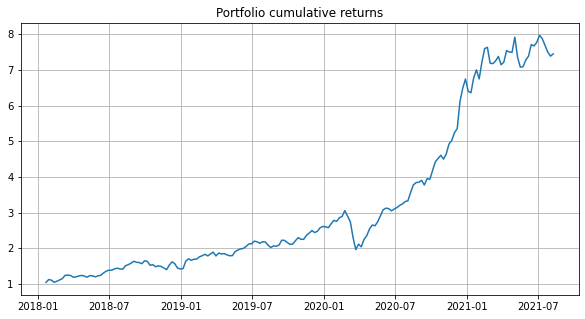

In [23]:
cum_returns = np.exp(np.log1p(average_return).cumsum())

plt.figure(figsize= (10,5))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()

## Momentun signal computation:

In [24]:
momentum_signal = prices.resample('w').mean()

"""
return of the securities of last 6 weeks prior to the week we will be trading
we are not using current weeks because:
1. traditional momentum has atendency of short term reversal and longer term trend
2. it algns with execution strategy interms of  consistent with actual execution because
if we receive a signal on close price, we won't be able to execute immedeate
"""
momentum_signal = (momentum_signal.apply(func = lambda x: x.shift(1)/x.shift(7) - 1, axis = 0))
momentum_signal # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,0.256624,0.308538,0.106980,0.187551,0.032658,0.053702,-0.070858,0.102439
2021-07-18,0.116011,0.303590,0.017786,0.161628,-0.016055,-0.015257,-0.092064,0.084353
2021-07-25,0.011918,0.218272,-0.024912,0.136242,0.031960,-0.063552,-0.051574,0.082343


creating signal >= 7 means 1, <=2 means -1, else 0

In [25]:
# ranking of the returns
rank_df = momentum_signal.rank(axis=1,method='average', numeric_only=True, 
                            na_option='keep', ascending=False, pct=False)
rank_df

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,2.0,1.0,4.0,3.0,7.0,6.0,8.0,5.0
2021-07-18,3.0,1.0,5.0,2.0,7.0,6.0,8.0,4.0
2021-07-25,5.0,1.0,6.0,2.0,4.0,8.0,7.0,3.0


In [26]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

rank_df.tail() # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-07-11,-1,-1,0,0,1,0,1,0
2021-07-18,0,-1,0,-1,1,0,1,0
2021-07-25,0,-1,0,-1,0,1,1,0
2021-08-01,1,-1,0,0,0,1,0,-1
2021-08-08,1,-1,0,0,0,1,0,-1


In [27]:
rank_df = momentum_signal.rank(axis =1)
rank_df # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,7.0,8.0,5.0,6.0,2.0,3.0,1.0,4.0
2021-07-18,6.0,8.0,4.0,7.0,2.0,3.0,1.0,5.0
2021-07-25,4.0,8.0,3.0,7.0,5.0,1.0,2.0,6.0


In [28]:
# returns = prices.pct_change()
portfolio = np.multiply(rank_df, weekly_returns)
portfolio.tail(50) # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2020-08-30,-0.152769,-0.029856,0.158014,-0.070322,0.126617,0.093200,-0.005003,0.024366
2020-09-06,0.393900,-0.076792,0.188440,-0.036615,0.018627,0.022455,0.020248,0.172266
2020-09-13,0.416726,-0.286260,-0.262015,-0.138048,-0.002267,0.211531,-0.089531,-0.245632
2020-09-20,0.960618,-0.049687,0.750181,0.369512,-0.073506,0.056658,0.096830,0.053465
2020-09-27,-1.011627,0.277451,0.423494,-0.078052,-0.142510,-0.420839,0.271628,-0.044874
2020-10-04,0.246451,0.781804,0.482643,0.383927,-0.001703,0.046838,0.401524,-0.002796
2020-10-11,0.521909,0.011600,0.154343,0.551695,-0.019474,0.176435,0.485103,0.006976
2020-10-18,0.030298,0.018016,-0.244004,0.667045,0.031547,0.084652,0.196994,0.090759
2020-10-25,-0.334156,-0.086579,-0.154548,-0.173920,-0.009359,0.318376,0.152225,0.001307


In [29]:
portfolio_returns = portfolio.sum(axis=1) / 3
portfolio_returns

Date
2018-01-07    0.000000
2018-01-14    0.000000
2018-01-21    0.000000
2018-01-28    0.000000
2018-02-04    0.000000
                ...   
2021-07-11   -0.222452
2021-07-18   -0.448404
2021-07-25    0.014981
2021-08-01   -0.148972
2021-08-08    0.000230
Freq: W-SUN, Length: 188, dtype: float64

In [30]:
cum_returns

Date
2018-01-07         NaN
2018-01-14         NaN
2018-01-21    1.041337
2018-01-28    1.121834
2018-02-04    1.105923
                ...   
2021-07-11    7.876947
2021-07-18    7.687320
2021-07-25    7.499607
2021-08-01    7.385159
2021-08-08    7.447161
Freq: W-SUN, Length: 188, dtype: float64

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


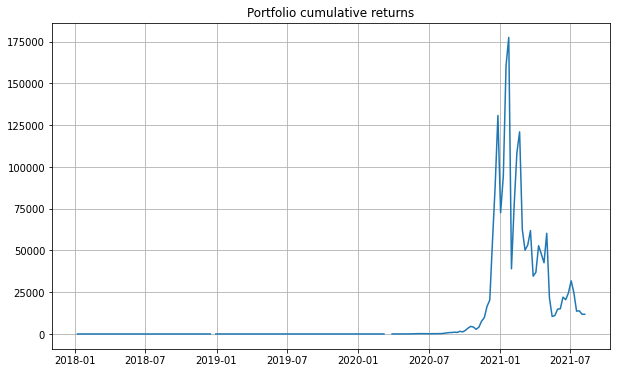

In [31]:
cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())
plt.figure(figsize= (10,6))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()

In [19]:
# for col in rank_df.columns:
#     rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

# rank_df.tail() # sanity check

In [20]:
# portfolio = np.multiply(rank_df, returns)
# portfolio.tail(50) # sanity check

In [21]:
# portfolio_returns = portfolio.sum(axis=1) / 3
# portfolio_returns

In [22]:
# cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())

# plt.figure(figsize= (15,8))
# plt.plot(cum_returns)
# plt.title('Portfolio cumulative returns')
# plt.grid(True); plt.show()

## linear least-squares regression for trendlines

In [32]:
tickers=["SGRY"]
start = datetime(2018,1,1)
 
df = yf.download(tickers,start)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,12.100000,13.350000,12.100000,13.350000,13.350000,354100
2018-01-03,13.400000,13.450000,12.775000,12.900000,12.900000,410100
2018-01-04,12.900000,13.250000,12.550000,12.900000,12.900000,430500
2018-01-05,13.000000,13.090000,12.550000,12.650000,12.650000,291000
2018-01-08,12.550000,13.150000,12.350000,13.150000,13.150000,566200
...,...,...,...,...,...,...
2021-07-30,54.730000,56.139999,54.310001,54.560001,54.560001,140700
2021-08-02,54.750000,56.834999,54.380001,54.540001,54.540001,218600
2021-08-03,54.610001,56.720001,53.220001,56.419998,56.419998,306600


In [33]:
df_len = len(df)
df['Number'] = np.arange(df_len)+1
df_high = df.copy()
df_low = df.copy()
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Number
Date,,,,,,,
2021-07-30,54.730000,56.139999,54.310001,54.560001,54.560001,140700,901
2021-08-02,54.750000,56.834999,54.380001,54.540001,54.540001,218600,902
2021-08-03,54.610001,56.720001,53.220001,56.419998,56.419998,306600,903
2021-08-04,53.740002,54.650002,46.509998,47.980000,47.980000,1190500,904
2021-08-05,47.919998,50.090000,47.845001,49.040001,49.040001,372200,905


Here we are selecting 2 higher and lower data points from DataFrame. The computation returned only 2 sets of DataFrame rows where the data points broke above or below the calculated linear regression line in either case.

In [34]:
while len(df_high)>2:
    slope, intercept, r_value, p_value, std_err = linregress(x=df_high['Number'], y=df_high['High'])
    df_high = df_high.loc[df_high['High'] > slope * df_high['Number'] + intercept]
    
df_high.tail()

,Open,High,Low,Close,Adj Close,Volume,Number
Date,,,,,,,
2018-01-16,15.35,16.299999,15.150000,15.650000,15.650000,823900,10
2021-06-25,67.75,69.580002,66.480003,67.050003,67.050003,1155800,877


In [35]:
while len(df_low)>2:
    slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low['Low'])
    df_low = df_low.loc[df_low['Low'] < slope * df_low['Number'] + intercept]
    
df_low.tail()

,Open,High,Low,Close,Adj Close,Volume,Number
Date,,,,,,,
2019-08-15,6.29,6.29,5.375,5.52,5.52,428300,408
2020-03-18,5.39,5.39,4.000,5.13,5.13,774400,556


So, now that We have 2 higher and lower data points calculated, let’s take those 2 points in both uptrend and downtrend calculation for scipy.stats.linregress method. The method returns a slope, interception, p&r values also standard errors of a function. 

In [36]:
slope, intercept, r_value, p_value, std_err = linregress(x=df_high['Number'], y=df_high['Close'])
df['Uptrend'] = slope * df['Number'] + intercept
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Number,Uptrend
Date,,,,,,,,
2021-07-30,54.730000,56.139999,54.310001,54.560001,54.560001,140700,901,68.472841
2021-08-02,54.750000,56.834999,54.380001,54.540001,54.540001,218600,902,68.532125
2021-08-03,54.610001,56.720001,53.220001,56.419998,56.419998,306600,903,68.591410
2021-08-04,53.740002,54.650002,46.509998,47.980000,47.980000,1190500,904,68.650695
2021-08-05,47.919998,50.090000,47.845001,49.040001,49.040001,372200,905,68.709980


In [37]:
slope, intercept, r_value, p_value, std_err = linregress(x=df_low['Number'], y=df_low['Close'])
df['Downtrend'] = slope * df['Number'] + intercept
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Number,Uptrend,Downtrend
Date,,,,,,,,,
2021-07-30,54.730000,56.139999,54.310001,54.560001,54.560001,140700,901,68.472841,4.220879
2021-08-02,54.750000,56.834999,54.380001,54.540001,54.540001,218600,902,68.532125,4.218244
2021-08-03,54.610001,56.720001,53.220001,56.419998,56.419998,306600,903,68.591410,4.215609
2021-08-04,53.740002,54.650002,46.509998,47.980000,47.980000,1190500,904,68.650695,4.212973
2021-08-05,47.919998,50.090000,47.845001,49.040001,49.040001,372200,905,68.709980,4.210338


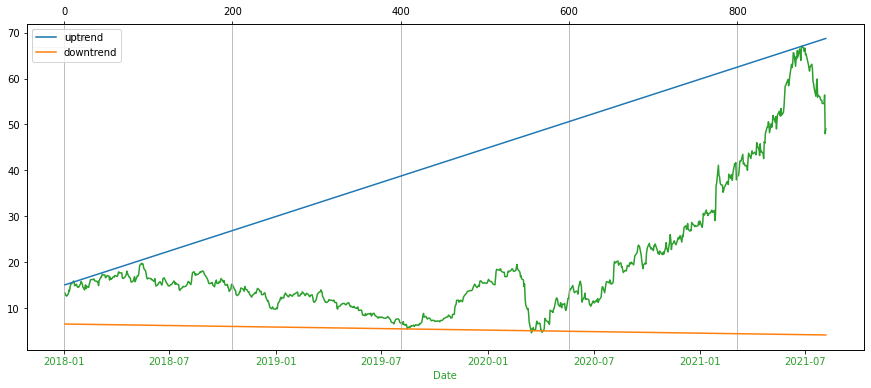

In [39]:
# draw the closing price and related trendlines (uptrend and downtrend)
fig, ax1 = plt.subplots(figsize=(15,6))

color = 'tab:green'
xdate = [x.date() for x in df.index]
ax1.set_xlabel('Date', color=color)
ax1.plot(xdate, df.Close, label="close", color=color)
ax1.tick_params(axis='x', labelcolor=color)
ax1.legend()

ax2 = ax1.twiny()
ax2.plot(df.Number, df.Uptrend, label="uptrend")
ax2.plot(df.Number, df.Downtrend, label="downtrend")

plt.legend()
plt.grid()
plt.show()